Given zip code, day of week, and time of day. Predict incidents

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
path = 'Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv'
data = pd.read_csv(path, parse_dates=True)


In [4]:
# data[['DELETE - Zip Codes 2 2', Time, DayOfWeek]] # WE USE THIS DATA IN THE MODEL

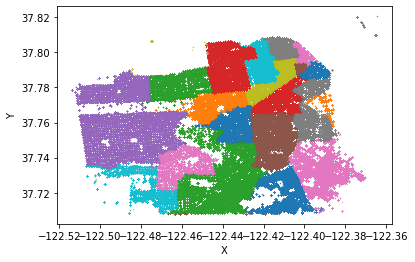

In [5]:
# plot incidents. Color by zipcode
zipcodes = data['DELETE - Zip Codes 2 2'].unique()

fig, ax = plt.subplots()
colors = ['C' + str(i) for i in range(len(zipcodes))]


for zipcode,color in zip(zipcodes,colors):
    data[data['DELETE - Zip Codes 2 2']==zipcode].plot.scatter(x='X', y='Y', ax=ax, color=color, s=0.1)

In [6]:
data.head(3)

,PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,...,Fix It Zones as of 2017-11-06 2 2,DELETE - HSOC Zones 2 2,Fix It Zones as of 2018-02-07 2 2,"CBD, BID and GBD Boundaries as of 2017 2 2","Areas of Vulnerability, 2016 2 2",Central Market/Tenderloin Boundary 2 2,Central Market/Tenderloin Boundary Polygon - Updated 2 2,HSOC Zones as of 2018-06-05 2 2,OWED Public Spaces 2 2,Neighborhoods 2
0,4133422003074,41334220,3074,ROBBERY,"ROBBERY, BODILY FORCE",Monday,11/22/2004,17:50,INGLESIDE,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5118535807021,51185358,7021,VEHICLE THEFT,STOLEN AUTOMOBILE,Tuesday,10/18/2005,20:00,PARK,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4018830907021,40188309,7021,VEHICLE THEFT,STOLEN AUTOMOBILE,Sunday,02/15/2004,02:00,SOUTHERN,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# setup hour column to use over time
def get_hour(time):
    return int(time.split(':')[0])
data['hour'] = data.Time.apply(get_hour)

In [9]:
import datetime as dt
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data.Date.dt.year
data['Month'] = data.Date.dt.month
data2013To2017 = data[data['Date'].dt.year.isin([2013,2014,2015,2016,2017])].dropna()

data2018 = data[data['Date'].dt.year == 2018].dropna()

In [10]:
data2013To2017 = data2013To2017.groupby(['DELETE - Zip Codes 2 2','hour','Year','Month']).IncidntNum.size().reset_index()
data2018 = data2018.groupby(['DELETE - Zip Codes 2 2','hour','Year','Month']).IncidntNum.size().reset_index()

In [18]:
data2018.head(3)

,DELETE - Zip Codes 2 2,hour,Year,Month,IncidntNum
0,28852.0,0,2018,1,1
1,28852.0,0,2018,2,1
2,28852.0,1,2018,2,1


In [40]:
X_train = data2013To2017[['DELETE - Zip Codes 2 2','hour','Year','Month']]
y_train = data2013To2017['IncidntNum']

X_test = data2018[['DELETE - Zip Codes 2 2','hour','Year','Month']]
y_test = data2018.IncidntNum


"Your goal is to build a model that predicts the number of crime incidents that will occur in a given zip code, given the day of the week, and the time of day."

In [90]:
# pipeline
#setup pipe
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#num_features = ['Year'] # Here incase I need to change it later
num_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

cat_features = ['DELETE - Zip Codes 2 2','hour','Month', 'Year']
cat_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')) # onehot encoder can take: handle_unknwon='ignore'
])

feature_processor = ColumnTransformer(transformers=[
    ('num_processor', num_processor, num_features),
    ('cat_processor', cat_processor, cat_features),
])

pipe = Pipeline(steps=[
    ('feature_processor', feature_processor),
    ('forest', RandomForestRegressor(max_depth=5))
])



In [91]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('feature_processor',
                 ColumnTransformer(transformers=[('num_processor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Year']),
                                                 ('cat_processor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['DELETE - Zip Codes 2 2',
                                                   'hour', 'Month',
                                                   'Year'])])),
                ('forest', RandomForestRegressor(max_depth=5))])

In [127]:
# grid search
from sklearn.model_selection import GridSearchCV
depth_list = [2,4,8,16,32,64]
param_dic = {'forest__max_depth': depth_list}

grid = GridSearchCV(pipe,param_dic, cv=5, n_jobs=-1, verbose=1, error_score='raise', scoring='neg_mean_absolute_error')
grid.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('feature_processor',
                                        ColumnTransformer(transformers=[('num_processor',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['Year']),
                                                                        ('cat_processor',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['DELETE '
                                                                          '- '
                                                                          'Zip '
                                                                          'Codes '
                                                                          '2 2',
                                                                          'hour',
                                                                          'Month',
                                                                          'Year'])])),
                                       ('forest',
                                        RandomForestRegressor(max_depth=5))]),
             n_jobs=-1, param_grid={'forest__max_depth': [2, 4, 8, 16, 32, 64]},
             scoring='neg_mean_absolute_error', verbose=1)

In [128]:
best_pipe = grid.best_estimator_
y_test_pred = best_pipe.predict(X_test)


In [129]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def TestPipe(y,y_pred):
    print('params:',grid.best_params_)
    # MSE
    print('MSE:',np.sqrt(mean_squared_error(y,y_pred)))
    # MAE
    print('MAE:',mean_absolute_error(y,y_pred))
    # MAPE
    print('MAPE', mean_absolute_percentage_error(y,y_pred))

TestPipe(y_test,y_test_pred)

params: {'forest__max_depth': 8}
MSE: 2.996082811867896
MAE: 2.150593583459599
MAPE 0.9236982841984682


## A Mean absolute value of 2.15 is okay. There seems to be a wide range of incidents that can happen in a given year, month, and hour but my model has a shorter range. Model could be improved, there's diferences between y_test values and the prediction data

<AxesSubplot:title={'center':'2018 incidents'}>

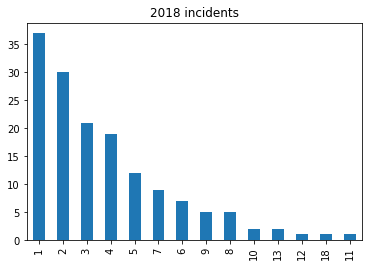

In [141]:
y_test.value_counts().plot.bar(title='2018 incidents')

<AxesSubplot:title={'center':'2018 predicted incidents rounded'}, xlabel='0'>

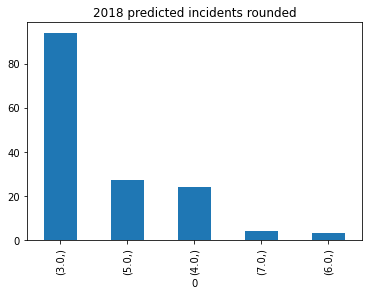

In [142]:
myTable = pd.DataFrame(np.round(y_test_pred))
myTable.value_counts().plot.bar(title='2018 predicted incidents rounded')